# Aim: 
1. Implement differnt architectures 

    1. simple dnn 
    2. Lstm 
    3. cnn
    4. lstm + cnn 
    5. lstm + cnn using activation 


2. Using External Data to increase performace 
    

# Imports  
## may 07

In [92]:
import warnings
warnings.filterwarnings('ignore')
import os

from wordcloud import WordCloud, STOPWORDS 
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re


# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Tools for preprocessing input data
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
# Tools for creating ngrams and vectorizing input data
import gensim

from gensim.models import Word2Vec, Phrases



# Tools for building a model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional,Flatten,GlobalMaxPool1D,Conv1D,MaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences




from keras.optimizers import Adam

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix



#early stopping 

from keras.callbacks import EarlyStopping


In [2]:
os.listdir('../input')


['word2vec-nlp-tutorial', 'imdb-review-dataset']

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Loading Dataset 

In this section we are going to load the train,test and additional data and combining them 
we also require to transform the additioal data before combining it.


In [4]:
train_data = pd.read_table('../input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip')
additional_dataset = pd.read_csv('../input/imdb-review-dataset/imdb_master.csv',encoding = 'latin-1')
test_data = pd.read_table('../input/word2vec-nlp-tutorial/testData.tsv.zip')

In [5]:
train_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
additional_dataset.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


# Transforming additional dataset

The following operations are performed:

    1. column names are changed are changed to match the train dataset
        a. labels -> sentiment 
        b. Unnamed: 0 -> id
        
    2. dropping file column    
    
    3. In the sentiment column 
        a. positive is changed to 1
        b. negavite is changed to 0
        


In [7]:
additional_dataset.rename(columns = {'label':'sentiment','Unnamed: 0':'id',},inplace = True)
additional_dataset.head()

,id,type,review,sentiment,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [8]:
additional_dataset.drop(columns = ['type','file'],inplace  = True)

additional_dataset.head()

,id,review,sentiment
0,0,Once again Mr. Costner has dragged out a movie...,neg
1,1,This is an example of why the majority of acti...,neg
2,2,"First of all I hate those moronic rappers, who...",neg
3,3,Not even the Beatles could write songs everyon...,neg
4,4,Brass pictures (movies is not a fitting word f...,neg


In [9]:
additional_dataset.replace({'neg':0,'pos':1},inplace = True)
additional_dataset['sentiment'].value_counts()

unsup    50000
1        25000
0        25000
Name: sentiment, dtype: int64

We only require positive and negative sentiments we will be dropping all rows with sentiment unsup.

In [10]:
#removing labels with unsup
additional_dataset = additional_dataset[additional_dataset.sentiment != 'unsup']
additional_dataset.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         50000 non-null  int64 
 1   review     50000 non-null  object
 2   sentiment  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


# Combine train and additioal data

We are adding 50k more samples to our train dataset

In [11]:
new_data = pd.concat([train_data,additional_dataset],axis = 0)
new_data.reset_index(drop =  True,inplace = True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         75000 non-null  object
 1   sentiment  75000 non-null  object
 2   review     75000 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


# Checking Class Balance
The data looks balanced we dont need to do any balancing 

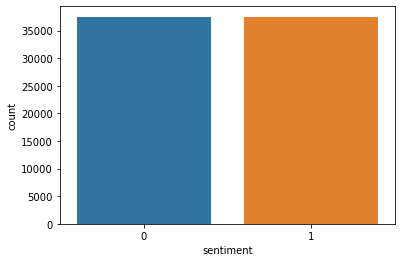

In [12]:
sns.countplot(new_data['sentiment'])

# Visualising the words using WordClouds 
This step shows the words used in our dataset, we can find misseplled words, maybe include words, 
which are common in both classes in the stop word list. 

The getWordCloud method is used to generate and display the word cloud.


In [13]:
def getWordCLoud(x,withLower = False):
    
    # the word cloud accepts a string
    comment_words = " "
    
    for val in x: 
        
        if withLower:
            comment_words += " " + val.lower()
        else:
            comment_words += " " + val
            
    
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 
        

### WordCloud for All reviews 

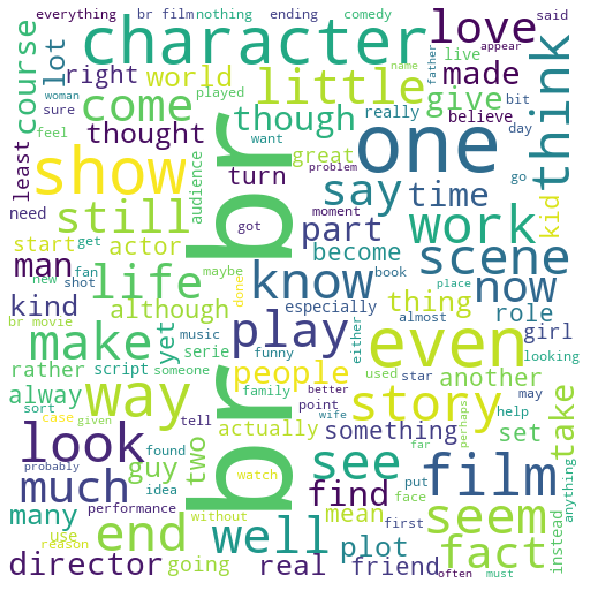

In [14]:
getWordCLoud(x = new_data['review'],withLower = True)

## WordCloud for Positive Class

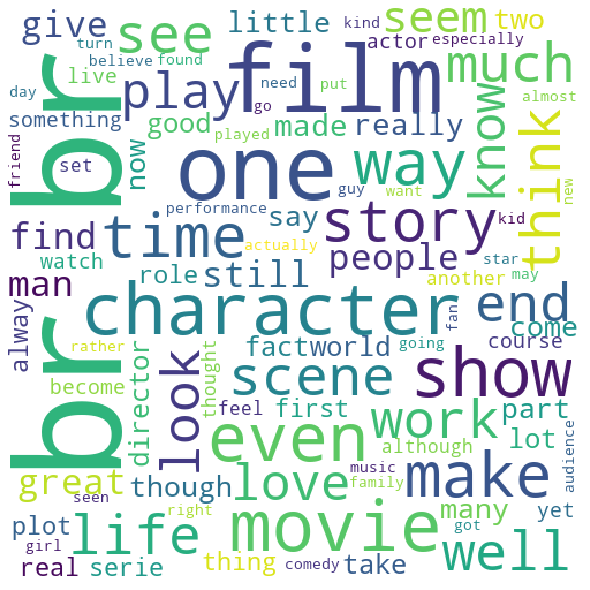

In [15]:
getWordCLoud(x = new_data[new_data.sentiment == 1]['review'],withLower = True)

## WordCloud for Positive Class

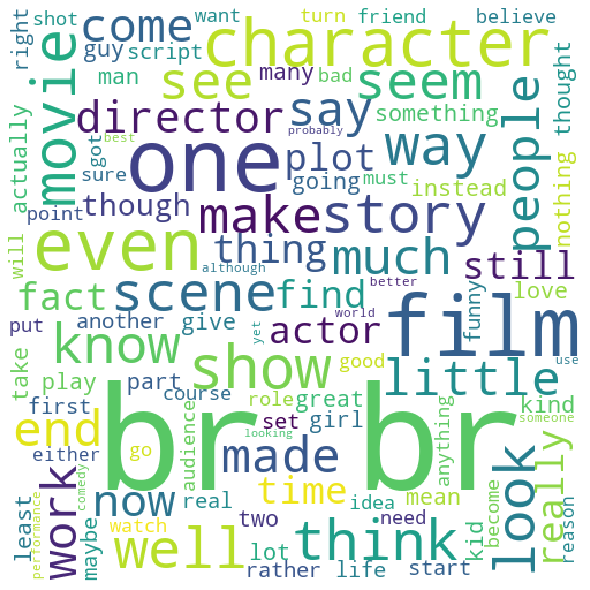

In [16]:
getWordCLoud(x = new_data[new_data.sentiment == 0]['review'],withLower = True)

The word br will be included in our stopword list.

# Preprocessig Part

### Steps:

    1. remove html tags 
    2. remove punctuations
    3. remove stopwords     
    4. lowercase 
    5. lemmatize words 
    6. remove word with length lower then N 
        Here N can be considered as  a hyper parameter.
    
    


In [18]:
# list(map(lambda x: lemmatizer.lemmatize(x,'v'),['running','ducking','jumping','rams']))

In [20]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


### including br in stopwrds 


stop_words.append("br")



def clean_text(x,N = 2):    

    
    # remove html tags
    regex = re.compile('<.*?>')
    sent =  re.sub(regex, '', x)

    #remove punctuations, numbers.
    sent = re.sub('[!@#$%^&*()\n_:><?\-.{}|+-,;""``~`—]|[0-9]|/|=|\[\]|\[\[\]\]',' ',sent)
    sent = re.sub('[“’\']','',sent)   
    sent = sent.replace('//',' ')
    
    #lemmatization 
    
    final_sent = ""
    
    for token in word_tokenize(sent):
        
        if len(set(token)) > N and token not in stop_words:
            final_sent += lemmatizer.lemmatize(token,'v') + " "
    
 
    return final_sent.lower()


tmp_sent  = "AAAAAA  br br <html> <h1> run <i>running</i> ban banned dancing dance 1 2 3  4   5 5  5 !@#$%^&*(){{:><<< MMM<>?PLOKIU}} </h1> </html>"

print('with default value of N = 2')
print(clean_text(tmp_sent))

print('with N = 0')
print(clean_text(tmp_sent,N=0))

with default value of N = 2
run run ban ban dance dance plokiu 
with N = 0
aaaaaa run run ban ban dance dance plokiu 


In [52]:
new_data['preprocessed_review'] = new_data['review'].map(clean_text)
test_data['preprocessed_review'] = test_data['review'].map(clean_text)

# WordCloud After preprocessing 

## For +ve CLass

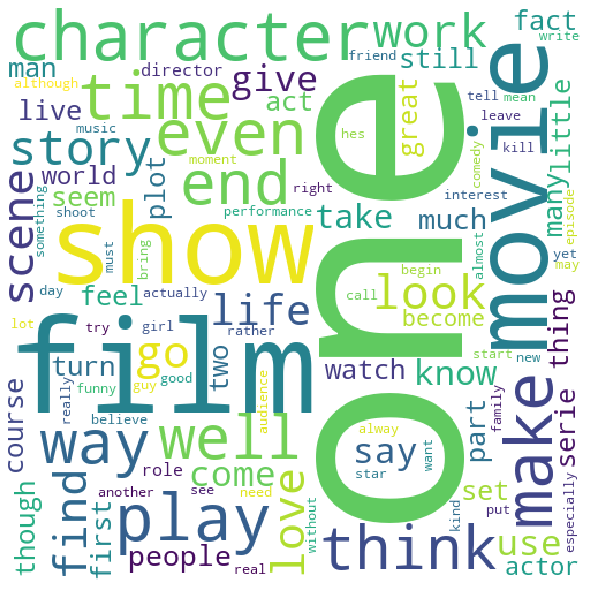

In [22]:
getWordCLoud(x = new_data[new_data.sentiment == 1]['preprocessed_review'],withLower = True)

## For -ve Class

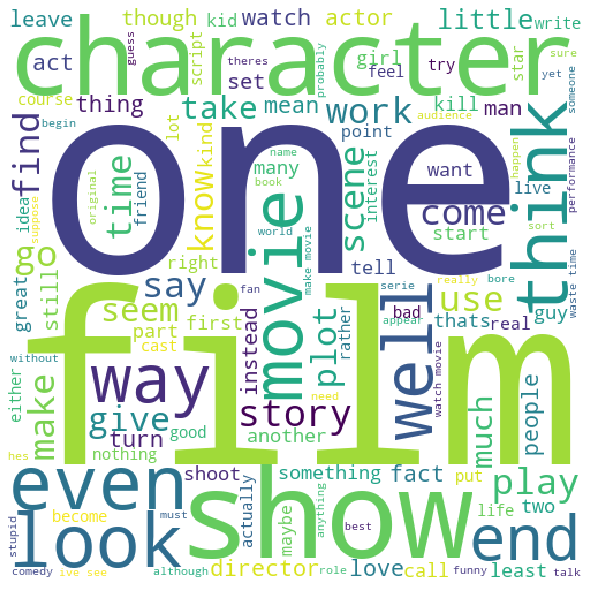

In [23]:
getWordCLoud(x = new_data[new_data.sentiment == 0]['preprocessed_review'],withLower = True)

The words show,flim,one are common in both +ve and -ve its better to remove them.

# Create a vocab file

In [24]:
from collections import Counter 

def create_vocab(data):

    vocab = Counter()

    for i in data:
        vocab.update(i.split())
        
        
    return vocab     

In [25]:
#size of vocab

data = list(new_data['preprocessed_review']) + list(test_data['preprocessed_review'])

vocab = create_vocab(data)

len(vocab)

120982

In [40]:
sorted(vocab.items())

[('\x10own', 2),
 ('\\aaaaatch', 1),
 ('\\aahhhh', 1),
 ('\\aaila', 1),
 ('\\aau', 1),
 ('\\abbott', 1),
 ('\\abc', 2),
 ('\\abernethie\\', 1),
 ('\\abilene', 1),
 ('\\abilities\\', 1),
 ('\\about', 4),
 ('\\about\\', 2),
 ('\\abracadabrantesque\\', 1),
 ('\\abraham', 2),
 ('\\abre', 1),
 ('\\abscessed', 1),
 ('\\absence', 1),
 ('\\absolute', 2),
 ('\\absolutely', 1),
 ('\\absorbs\\', 1),
 ('\\abundance', 1),
 ('\\abyss\\', 1),
 ('\\acacia\\', 2),
 ('\\academic', 1),
 ('\\academy\\', 1),
 ('\\accent', 1),
 ('\\acceptable\\', 2),
 ('\\accessible\\', 1),
 ('\\accident\\', 2),
 ('\\accidentally\\', 5),
 ('\\acclaimed\\', 1),
 ('\\according', 3),
 ('\\accurate\\', 1),
 ('\\ace\\', 1),
 ('\\aces', 2),
 ('\\ach', 1),
 ('\\achtung\\', 1),
 ('\\acid', 2),
 ('\\acrobatty', 1),
 ('\\act', 1),
 ('\\act\\', 4),
 ('\\acted\\', 1),
 ('\\acting', 7),
 ('\\acting\\', 25),
 ('\\action', 5),
 ('\\action\\', 25),
 ('\\actioner\\', 1),
 ('\\actor', 1),
 ('\\actor\\', 10),
 ('\\actors', 3),
 ('\\actors\\',

In [42]:
sorted(vocab.items(),key= lambda kv:(kv[1], kv[0]),reverse = True)


[('film', 190589),
 ('the', 183987),
 ('movie', 173815),
 ('one', 105981),
 ('make', 91385),
 ('like', 88485),
 ('get', 70701),
 ('time', 63203),
 ('this', 59849),
 ('good', 59146),
 ('character', 56184),
 ('watch', 54610),
 ('even', 50566),
 ('think', 48692),
 ('would', 48455),
 ('really', 46163),
 ('story', 45797),
 ('show', 43487),
 ('well', 42925),
 ('look', 39298),
 ('much', 38608),
 ('say', 38336),
 ('know', 38005),
 ('end', 37873),
 ('bad', 36743),
 ('people', 36521),
 ('great', 36215),
 ('also', 35941),
 ('first', 35114),
 ('take', 34439),
 ('see', 34434),
 ('give', 34194),
 ('go', 34193),
 ('play', 34158),
 ('act', 34051),
 ('dont', 33941),
 ('love', 33932),
 ('come', 32627),
 ('movies', 32117),
 ('find', 31690),
 ('way', 31219),
 ('could', 30419),
 ('but', 28936),
 ('and', 28216),
 ('seem', 28013),
 ('work', 27658),
 ('plot', 27449),
 ('two', 27026),
 ('many', 26884),
 ('its', 26695),
 ('want', 26185),
 ('never', 25943),
 ('life', 25373),
 ('best', 25196),
 ('try', 24837),
 (

### from the output its clear that we will need to do more porcessing
1. replacing \\ 
2. removing show, film,the,one 

In [53]:
to_remove = ['show','film','the','one']

def preProcess2(sent):

    tmp = ''
    for word in sent.split():

            if word not in to_remove:
                
                word = word.replace('//',' ')
                word = word.replace('\\',' ')
                tmp += word + ' '

    return tmp    

new_data['preprocessed_review'] = new_data['preprocessed_review'].map(preProcess2)

In [57]:
test_data['preprocessed_review'] = test_data['preprocessed_review'].map(preProcess2)

In [56]:
new_data['preprocessed_review'][2]

'start manager nicholas bell give welcome investors robert carradine primal park secret project mutate primal animal use fossilize dna like ¨jurassik park¨ scientists resurrect natures fearsome predators sabretooth tiger smilodon scientific ambition turn deadly however high voltage fence open creature escape begin savagely stalk prey human visitors tourists scientific meanwhile youngsters enter restrict area security center attack pack large pre historical animals deadlier bigger addition security agent stacy haiduk mate brian wimmer fight hardly carnivorous smilodons sabretooths course real star star astound terrifyingly though convince giant animals savagely stalk prey group run afoul fight natures fearsome predators furthermore third sabretooth dangerous slow stalk victims movie deliver goods lot blood gore behead hair raise chill full scar sabretooths appear mediocre special effect story provide excite stir entertainment result quite bore giant animals majority make computer genera

In [ ]:
# # Word2Vec Embeddings

# !wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
# !gunzip GoogleNews-vectors-negative300.bin

In [59]:
data = list(new_data['preprocessed_review']) + list(test_data['preprocessed_review'])

new_vocab = create_vocab(data)
len(new_vocab)

102337

# The new vocab has reduced after preprocessing 2 

In [60]:
len(vocab) - len(new_vocab)

18645

#### Words which were removed 

In [62]:
set(vocab).difference(new_vocab)

{'\\effects\\',
 '\\fille',
 '\\prettier\\',
 '\\herbie',
 'nevsky\\',
 'swamp\\',
 '\\giant\\',
 '\\issues\\',
 '\\happening\\',
 '\\misunderstandings\\',
 'dinner\\',
 '\\oshawa',
 'swell\\',
 '\\lou\\',
 'jeopardy\\',
 'decree\\',
 '\\best\\',
 'eternity\\',
 'poor\\',
 'recommendations\\',
 '\\heartland',
 'zuotian\\',
 'photo\\',
 '\\terrorizing\\',
 '\\rise',
 '\\fraculater',
 '\\bennifer\\',
 '\\excellent',
 'doone\\',
 'grandmother\\',
 'hello\\',
 '\\client\\',
 'limits\\',
 '\\sucked',
 '\\gear\\',
 'jaguar\\',
 '\\mutantes',
 'bats\\',
 '\\enjoyed\\',
 'never\\',
 '\\outcome',
 'banks\\',
 'beans\\',
 '\\dada',
 '\\sixteen',
 'porno\\',
 'belching\\',
 'frustration\\',
 'communication\\',
 '\\gypo\\',
 '\\spock',
 '\\houseboy',
 'scenes\\',
 '\\call',
 '\\mah\\',
 'waxwork\\',
 '\\finale\\',
 'metamorphosis\\',
 'ballgame\\',
 'splash\\',
 'cruelty\\',
 'numbers\\',
 'youths\\',
 '\\products\\',
 'burnett\\',
 'sec\\',
 'snatch\\',
 '\\disclosure\\',
 'sandler\\',
 'bilge\\'

# Calculating the input_length

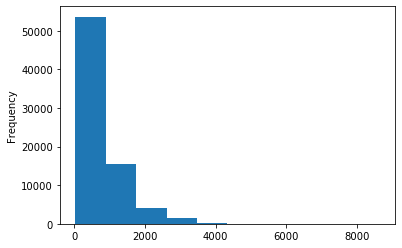

In [63]:
new_data['preprocessed_review'].map(lambda x:len(x)).plot(kind = 'hist')

In [66]:
# deciding parameters

vocal_size = len(new_vocab)
output_dims = 32
input_length = 500

# Embeddings
For embeddings I will be using the Embedding layer instead of using pre-trained embeddings. 
In the later section I have used Word2Vec

In [ ]:
# demo code for training own word2vec model and using tfidfvectorizer.

# embedding_vector_size = 256
# trigrams_model = Word2Vec(
#     sentences = trigrams[bigrams[all_reviews]],
#     size = embedding_vector_size,
#     min_count=3, window=5, workers=4)


# from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# vectorizer = TfidfVectorizer(analyzer = "word",   \
#                              tokenizer = None,    \
#                              preprocessor = None, \
#                              stop_words = None,   \
#                              max_features = 6000) 

# # The input to fit_transform should be a list of strings.
# train_data_features = vectorizer.fit_transform(train_data['processed_review'] )

# train_data_features = train_data_features.toarray()









## Tokenizing 

In [68]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(data)

entire_train_data = tokenizer.texts_to_sequences(new_data['preprocessed_review'])

padded_data = pad_sequences(entire_train_data, maxlen=input_length)

In [69]:
Y = new_data['sentiment']

In [70]:
Y.value_counts()

1    37500
0    37500
Name: sentiment, dtype: int64

# Splitting Data into train and validation 

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_data,
    Y.values,
    test_size=0.2,
    random_state=42)

In [73]:
X_train.shape,y_train.shape

((60000, 500), (60000,))

In [74]:
vocab_size = len(tokenizer.word_index) + 1

# Model 1 Embedded layer + Dense layers  score = 0.71

# Simple model

In [78]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=output_dims,input_length = input_length))
# model.add(LSTM(60, return_sequences = True))
# model.add(GlobalMaxPool1D())
model.add(Dense(102))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss="binary_crossentropy",
    optimizer= 'adam',
    metrics=['accuracy'])

model.summary()

print(model.input_shape)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           3274816   
_________________________________________________________________
dense_7 (Dense)              (None, 500, 102)          3366      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 102)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 102)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5150      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [79]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=2,
    
)

Train on 60000 samples, validate on 15000 samples
Epoch 1/2
60000/60000 [==============================] - 13s 219us/step - loss: 0.3450 - accuracy: 0.8487 - val_loss: 0.2677 - val_accuracy: 0.8925
Epoch 2/2
60000/60000 [==============================] - 11s 190us/step - loss: 0.2147 - accuracy: 0.9161 - val_loss: 0.2364 - val_accuracy: 0.9069


## LSTM Model

In [87]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size,output_dim=output_dims,input_length = input_length))
model_lstm.add(LSTM(60,return_sequences = True))
model_lstm.add(GlobalMaxPool1D())
# model_lstm.add(Flatten())
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(50,activation = 'sigmoid'))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(
    loss="binary_crossentropy",
    optimizer= 'adam',
    metrics=['accuracy'])

model_lstm.summary()

print(model_lstm.input_shape)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 32)           3274816   
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 60)           22320     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 60)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)               

In [88]:
history = model_lstm.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=3,
    
)

Train on 60000 samples, validate on 15000 samples
Epoch 1/3
60000/60000 [==============================] - 477s 8ms/step - loss: 0.3636 - accuracy: 0.8311 - val_loss: 0.2240 - val_accuracy: 0.9137
Epoch 2/3
60000/60000 [==============================] - 472s 8ms/step - loss: 0.1508 - accuracy: 0.9471 - val_loss: 0.2052 - val_accuracy: 0.9272
Epoch 3/3
60000/60000 [==============================] - 473s 8ms/step - loss: 0.0774 - accuracy: 0.9747 - val_loss: 0.1953 - val_accuracy: 0.9341


Even with the gpu the lstm model takes 8 min per epoch 

In [95]:

model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=output_dims,input_length = input_length))
model_lstm.add(tf.compat.v1.keras.layers.CuDNNLSTM(60,return_sequences = True))
model_lstm.add(tf.keras.layers.GlobalMaxPool1D())
# model_lstm.add(Flatten())
model_lstm.add(tf.keras.layers.Dropout(0.1))
model_lstm.add(tf.keras.layers.Dense(50,activation = 'sigmoid'))
model_lstm.add(tf.keras.layers.Dropout(0.1))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.compile(
    loss="binary_crossentropy",
    optimizer= 'adam',
    metrics=['accuracy'])

model_lstm.summary()

print(model_lstm.input_shape)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           3274816   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 500, 60)           22560     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [110]:
history = model_lstm.fit(
    x= X_train,
    y=y_train.astype('float32'),
    validation_data=(X_test,y_test.astype('float32')),
    batch_size=64,
    epochs=3,
    
)

Train on 60000 samples, validate on 15000 samples
Epoch 1/3
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.3851 - accuracy: 0.8060 - val_loss: 0.2411 - val_accuracy: 0.9069
Epoch 2/3
60000/60000 [==============================] - 59s 980us/sample - loss: 0.1531 - accuracy: 0.9464 - val_loss: 0.2011 - val_accuracy: 0.9255
Epoch 3/3
60000/60000 [==============================] - 57s 952us/sample - loss: 0.0823 - accuracy: 0.9732 - val_loss: 0.2253 - val_accuracy: 0.9301


Using CudNNLstm the training time was reduced to 1min from 8min and the performance was not affected.
We have seen around 80% reduction is training time.

# CNN of text Model

In [116]:
model_cnn = Sequential([
    
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=output_dims,input_length = input_length),
    tf.keras.layers.Conv1D(16,8,activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])


model_cnn.compile(
    loss="binary_crossentropy",
    optimizer= 'adam',
    metrics=['accuracy'])

model_cnn.summary()

print(model_cnn.input_shape)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           3274816   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 493, 16)           4112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 493, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 16)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3936)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3936)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [117]:
history = model_cnn.fit(
    x=X_train,
    y=y_train.astype('int32'),
    validation_data=(X_test, y_test.astype('int32')),
    batch_size=64,
    epochs=3,
    
)

Train on 60000 samples, validate on 15000 samples
Epoch 1/3
60000/60000 [==============================] - 34s 569us/sample - loss: 0.3240 - accuracy: 0.8471 - val_loss: 0.2051 - val_accuracy: 0.9265
Epoch 2/3
60000/60000 [==============================] - 34s 561us/sample - loss: 0.1338 - accuracy: 0.9522 - val_loss: 0.1756 - val_accuracy: 0.9365
Epoch 3/3
60000/60000 [==============================] - 33s 554us/sample - loss: 0.0726 - accuracy: 0.9745 - val_loss: 0.1794 - val_accuracy: 0.9378


cnn has the best performance in terms of time and accuracy compared to lstm and simple dnn

# cnn + LSTM

In [119]:
model_cnn_lstm =  Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=output_dims,input_length = input_length),
    tf.keras.layers.Conv1D(16,5,activation = 'relu',padding = 'same',strides = 1),
    tf.keras.layers.MaxPool1D(2),
    tf.compat.v1.keras.layers.CuDNNLSTM(64,name = 'lstm_1'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])


model_cnn_lstm.compile(
    loss="binary_crossentropy",
    optimizer= 'adam',
    metrics=['accuracy'])


# model.fit()
model_cnn_lstm.summary()
# model_cnn_lstm.summary()
print(model_cnn_lstm.get_layer('lstm_1').input_shape )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           3274816   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 16)           2576      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 16)           0         
_________________________________________________________________
lstm_1 (CuDNNLSTM)           (None, 64)                20992     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 3,298,449
Trainable params: 3,298,449
Non-trainable params: 0
____________________________________________

In [121]:
history = model_cnn_lstm.fit(
    x=X_train,
    y=y_train.astype('int32'),
    validation_data=(X_test, y_test.astype('int32')),
    batch_size=64,
    epochs=10,
    
)

Train on 60000 samples, validate on 15000 samples
Epoch 1/10
60000/60000 [==============================] - 50s 837us/sample - loss: 0.3262 - accuracy: 0.8541 - val_loss: 0.2045 - val_accuracy: 0.9257
Epoch 2/10
60000/60000 [==============================] - 44s 730us/sample - loss: 0.1267 - accuracy: 0.9593 - val_loss: 0.1881 - val_accuracy: 0.9371
Epoch 3/10
60000/60000 [==============================] - 44s 734us/sample - loss: 0.0596 - accuracy: 0.9829 - val_loss: 0.2098 - val_accuracy: 0.9416
Epoch 4/10
60000/60000 [==============================] - 43s 721us/sample - loss: 0.0332 - accuracy: 0.9905 - val_loss: 0.2264 - val_accuracy: 0.9424
Epoch 5/10
60000/60000 [==============================] - 43s 716us/sample - loss: 0.0239 - accuracy: 0.9934 - val_loss: 0.2687 - val_accuracy: 0.9432
Epoch 6/10
60000/60000 [==============================] - 44s 727us/sample - loss: 0.0116 - accuracy: 0.9969 - val_loss: 0.2993 - val_accuracy: 0.9445
Epoch 7/10
60000/60000 [====================

## Final Model with Attention

In [122]:
#with attention 

import tensorflow as tf

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


activation_layer = BahdanauAttention(10)

In [123]:


input_layer = tf.keras.layers.Input(shape = (input_length))

embedding_layer = tf.keras.layers.Embedding(vocab_size,output_dims)(input_layer)

output,state = tf.keras.layers.GRU(60,return_sequences=True,return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   activation = 'sigmoid')(embedding_layer)

output,weights = activation_layer(state,output)




output = tf.keras.layers.GRU(60,recurrent_initializer='glorot_uniform',activation = 'sigmoid')(weights)



sentiment = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)


modelwa = tf.keras.models.Model(inputs = [input_layer],outputs= [sentiment])

modelwa.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 32)           3274816   
_________________________________________________________________
gru (GRU)                    [(None, 500, 60), (None,  16920     
_________________________________________________________________
bahdanau_attention (Bahdanau ((None, 60), (None, 500,  1231      
_________________________________________________________________
gru_1 (GRU)                  (None, 60)                11340     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 61        
Total params: 3,304,368
Trainable params: 3,304,368
Non-trainable params: 0
___________________________________________________

In [124]:
modelwa.compile(loss= 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

history = modelwa.fit(
    x=X_train,
    y=y_train.astype('float32'),
    validation_data=(X_test, y_test.astype('float32')),
    batch_size=64,
    epochs=10,
    
)

Train on 60000 samples, validate on 15000 samples
Epoch 1/10
 2304/60000 [>.............................] - ETA: 16:57 - loss: 0.6952 - accuracy: 0.4978

KeyboardInterrupt: 

# Embeddings Using Word2Vec

# creating dataset set my method gave poor result or 0.5 acc

In [135]:
len(data)

100000

In [143]:
word2Vec_data = list(map(lambda x : x.split(),data))

In [145]:
# 
w2v = Word2Vec(sentences = word2Vec_data,
               window = 5, #neighbour words to consider 
               workers=-1,
               size= 128
              )

In [146]:
w2v.wv.vectors.shape

(45174, 128)

In [147]:
w2v.wv.save_word2vec_format('embeddings128.txt')

In [149]:
#
# w2v.wv.vocab['stuff'].index
# w2v.wv.index2word[409]
# w2v.wv.vectors[409].shape


(128,)

Now that we have trained the word2vec model we need to extract the word embeddings.

There are two ways of doing this
1. the word2vec model  provides a vocab dict with word to index mapping. 
   In this method we dont require the tokenizer.All the embeddings need to be extracted from 
   w2v.wv.vectors then we need to encode our text data using the index from word2vec model.

2. In method we store the vectors embeddings in a txt file using the method save_word2vec_format.
   Then using we load the embeddings from this file. and using the tokenizer to relate each word 
   with the vector. How is this possiable ?
   
   say the tokenizer encodes the word 'the' with index 9. We search for the embeddings for word 
   the in the embeddings here 'the' is the key. If the word is present in the embedding then the 
   vector is stored in the embedding_matrix at index 9. Like this we create a matrix of 
   size (vocab_size x vector_dims).
   
   
I Have used method 2    


# Loading embeddings using the embedding128.txt file[](http://)

In [159]:

# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
    parts = line.split()
    # key is string word, value is numpy array for vector
    embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding



def get_weight_matrix(embedding, vocab):
      # total vocabulary size plus 0 for unknown words
      vocab_size = len(vocab) + 1
      # define weight matrix dimensions with all 0
      weight_matrix = np.zeros((vocab_size, 128))
      # step vocab, store vectors using the Tokenizer's integer mapping
      for word, i in vocab.items():
      weight_matrix[i] = embedding.get(word)
      return weight_matrix

# load embedding from file
raw_embedding = load_embedding('embeddings128.txt')
# # get vectors in the right order

embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size, 128, weights=[embedding_vectors], input_length=input_length, trainable=True)


### 2 layer lstm 

In [162]:
model_w2v =  Sequential([
#     w2v.wv.get_keras_embedding(),
    embedding_layer,
    tf.keras.layers.LSTM(120,return_sequences = True,input_shape = (input_length,128)),
#     Conv1D(16,5,activation = 'relu',padding = 'same',strides = 1),
#     MaxPool1D(2),
    tf.keras.layers.LSTM(60,return_sequences = True),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])


model_w2v.compile(
    loss="binary_crossentropy",
    optimizer= 'adam',
    metrics=['accuracy'])


# model.fit()
model_w2v.summary()
# model_cnn_lstm.summary()
# print(model_cnn_lstm.get_layer('lstm_1').input_shape )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 128)          13099264  
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 120)          119520    
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 60)           43440     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 61        
Total params: 13,262,285
Trainable params: 13,262,285
Non-trainable params: 0
__________________________________________

In [164]:
history = model_w2v.fit(
    x=X_train,
    y=y_train.astype('int32'),
    validation_data=(X_test, y_test.astype('int32')),
    batch_size=64,
    epochs=1,
    
)

Train on 60000 samples, validate on 15000 samples
60000/60000 [==============================] - 237s 4ms/sample - loss: nan - accuracy: 0.4989 - val_loss: nan - val_accuracy: 0.5049


Embedding layer is better than Word2Vec

# LSTM

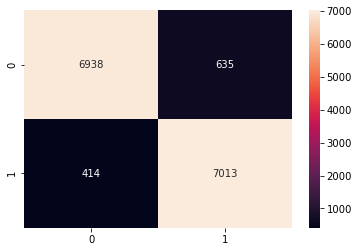

In [205]:
def plot_confusion(model,data):
    
    preds = np.round(model.predict(data[0]))
    
    sns.heatmap(confusion_matrix(data[1],preds),annot=True, fmt="d",xticklabels = [0,1])
    
    
    
plot_confusion(model_lstm,(X_test,y_test.astype('float32')))    

    

# CNN

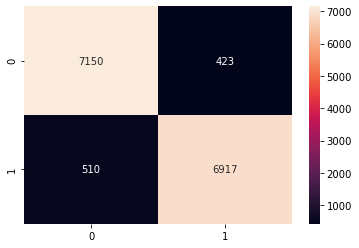

In [206]:
  
plot_confusion(model_cnn,(X_test,y_test.astype('float32')))    
    

# CNN + LSTM

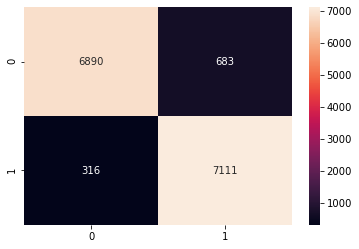

In [207]:
   
plot_confusion(model_cnn_lstm,(X_test,y_test.astype('float32')))    


# make prdiction
The test labels can actually be obtained from the id column. If a label ends with digit >=5 its 1 
else 0

In [208]:
test_data.head()

,id,review,preprocessed_review
0,12311_10,Naturally in a film who's main themes are of m...,naturally whos main theme mortality nostalgia ...
1,8348_2,This movie is a disaster within a disaster fil...,this movie disaster within disaster full great...
2,5828_4,"All in all, this is a movie for kids. We saw i...",movie kid saw tonight child love point kid exc...
3,7186_2,Afraid of the Dark left me with the impression...,afraid dark leave impression several different...
4,12128_7,A very accurate depiction of small time mob li...,accurate depiction small time mob life new jer...


In [210]:
true_labels = test_data['id'].map(lambda x : 1 if int(x.split('_')[-1])>=5 else 0)

In [211]:
true_labels

0        1
1        0
2        0
3        0
4        1
        ..
24995    1
24996    1
24997    0
24998    1
24999    1
Name: id, Length: 25000, dtype: int64

In [212]:

test_x = tokenizer.texts_to_sequences(test_data['preprocessed_review'])


X_test_pad = pad_sequences(test_x, maxlen=input_length)

print(X_test_pad.shape)



(25000, 500)


In [216]:
model_list = [model_lstm,model_cnn,model_cnn_lstm]
model_title = ['lstm','cnn','lstm+cnn']

for title,model in zip(model_title,model_list):
    
    score = accuracy_score(true_labels,np.round(model.predict(X_test_pad)))
    
    print(f'accuracy of {title} is {score}.')


accuracy of lstm is 0.96156.
accuracy of cnn is 0.96664.
accuracy of lstm+cnn is 0.96688.


1. Using cuDNNLSTM is better than LSTM if a cuda enabled  gpu is available.
2. Using WordCloud to visualize the text data helps removing unimportant words 
3. Using CNN layers is better than lstm
4. Attention layer takes too long to train 
5. Training Word2Vec Model Can be tricky